In [1]:
import pandas as pd                                         # type: ignore
import numpy as np                                          # type: ignore
import matplotlib.pyplot as plt                             # type: ignore
import seaborn as sns                                       # type: ignore    
from matplotlib.colors import LinearSegmentedColormap       # type: ignore

In [2]:
with open('data/PTOPER_202210_PWF25_OPFCMW.csv') as x:
    ncols = len(x.readline().split(','))
    
PWF25_links = pd.read_csv('data/PTOPER_202210_PWF25_OPFCMW.csv', usecols=range(0, ncols), skipinitialspace=True)
PWF25_links

,Bus #,Bus Name,Type,Pole #,P(MW),Q(Mvar),Satus,Dia,Hora
0,85,FOZ500-PR500,Rectifier,1,1236.00,604.88,ON,2,00-00
1,86,IBIUNA-SP345,Inverter,1,-1191.57,606.56,ON,2,00-00
2,85,FOZ500-PR500,Rectifier,2,1236.00,604.88,ON,2,00-00
3,86,IBIUNA-SP345,Inverter,2,-1191.57,606.56,ON,2,00-00
4,85,FOZ500-PR500,Rectifier,3,1236.00,604.88,ON,2,00-00
...,...,...,...,...,...,...,...,...,...
37627,3010,ESTREI-MG500,Inverter,2,0.00,0.00,OFF,29,23-30
37628,8100,XINGU--PA500,Rectifier,3,1565.00,734.17,ON,29,23-30
37629,9605,T.RIO--RJ500,Inverter,3,-1500.67,749.70,ON,29,23-30
37630,8100,XINGU--PA500,Rectifier,4,1565.00,734.17,ON,29,23-30


In [3]:
dfelo4 = PWF25_links[(PWF25_links['Bus #'] == 8100) & (PWF25_links['Pole #'].isin([1,2]))].groupby(by=['Dia', 'Hora']).agg({'P(MW)': sum, 'Q(Mvar)': sum})
dfelo4['Nome Elo'] = 'Elo_XINGU-ESTREI'

dfelo5 = PWF25_links[(PWF25_links['Bus #'] == 8100) & (PWF25_links['Pole #'].isin([3,4]))].groupby(by=['Dia', 'Hora']).agg({'P(MW)': sum, 'Q(Mvar)': sum})
dfelo5['Nome Elo'] = 'Elo_XINGU-T.RIO'

In [4]:
def flow_heatmap(dataset, col=None, frm=None, to=None, center=None):
    n_days = len(sorted(list(set(dataset['Dia'])))) # 28 days (October)
    days = list(set(dataset['Dia']))
    half_hour_list = sorted(list(set(dataset['Hora'])))
    n_half_hour = len(half_hour_list)
    half_hour_periods = pd.date_range(start='2023-10-17', periods=n_half_hour, freq='30T').strftime('%H:%M')

    active_power = np.array(dataset[col]).reshape(n_days, -1)
    heatmap_data = pd.DataFrame(active_power[::-1], 
                                index=[ind for ind in range(n_days+1, 0, -1) if ind in days], 
                                columns=half_hour_periods)
    
    # save path
    path ='E:/FERV/marck/202210_Melhor Previsao FNS/Plots/'
    frmstr = frm.split(' ', 1)[0]
    tostr  = to.split(' ', 1)[0]


    vmax = round(dataset[col].max(), 2)
    vmin = round(dataset[col].min(), 2)

    
    colors = [[0, 'darkblue'],
              [- vmin / (vmax - vmin), 'white'],
              [(1 - vmin)/ (vmax - vmin), 'white'],
              [1, 'darkred']]
    cmap = LinearSegmentedColormap.from_list('', colors) 

    if vmin >= 0:  
        cmap = sns.diverging_palette(230, 10, as_cmap=False)
    else:
      cmap = LinearSegmentedColormap.from_list('', colors) 

    n = 2
    plt.figure(figsize=(12, 6))
        
    sns.heatmap(heatmap_data, cmap=cmap, center=center, 
                xticklabels=n, cbar_kws={'label': f'{col}'}, 
                linewidths=0.1, linecolor="white", mask=heatmap_data == 0.0) 
        
    plt.xticks(rotation=45)

    plt.xlabel('Half Hour Period', weight='bold')
    plt.ylabel('Day of the Month', weight='bold')
    plt.title(fr'{frm}$\rightarrow${to}', 
              weight='bold', fontsize=22, x=0.5, y=1.03)
    
    if col == 'P(MW)':
      plt.annotate(fr'$Max. value:$ {round(vmax, 2)} MW',
                  xy=(10, 0.005))
      plt.annotate(fr'$Min. value:$ {round(vmin, 2)} MW',
                  xy=(25, 0.005))
      plt.savefig(path + f'MW/07 HVDC Heatmap/MW_HeatMap_{frmstr}_{tostr}.png')
      

    elif col == 'Q(Mvar)':
      plt.annotate(fr'$Max. value:$ {round(vmax, 2)} MVAr',
                  xy=(10, 0.005))
      plt.annotate(fr'$Min. value:$ {round(vmin, 2)} MVAr',
                  xy=(25, 0.005))
      plt.savefig(path + f'MVAr/07 HVDC Heatmap/MVAr_HeatMap_{frmstr}_{tostr}.png')

    plt.show()

In [5]:
def persistency_curve(dataset, col=None, frm=None, to=None, x_val=None, y_val=None, diff=None):
    fig, ax = plt.subplots(figsize=(12, 6))

    path ='E:/FERV/marck/202210_Melhor Previsao FNS/Plots/'

    frmstr = frm.split(' ', 1)[0]
    tostr  = to.split(' ', 1)[0]

    x = np.sort(np.array(dataset[col]))
    N = len(x)

    #y = np.arange(N) / float(N)
    y = np.linspace(1, N, N)
    
    N_cases = N
    
    # % of import and export cases
    cant_impt = len(dataset.loc[dataset[col] < 0])
    cant_expt = len(dataset.loc[dataset[col] > 0])
    impt = round((cant_impt / N_cases) * 100, 2)
    expt = round((cant_expt / N_cases) * 100, 2)
            
    ax.set_xlim(0, N+100)

    ax.set_xlabel('Number of hours', weight='bold') 
    ax.set_ylabel(f'{col}', weight='bold') 
    ax.set_title(fr'P. Curve {frm}$\rightarrow${to}', 
              weight='bold', fontsize=22, x=0.5, y=1.03)
    
    ax.text(x_val, y_val, f'$Import:$ {impt} % ({cant_impt} cases)', fontsize=12, 
         bbox = dict(facecolor = 'blue', alpha = 0.3), weight='bold')
    
    ax.text(x_val, y_val-diff, f'$Export:$ {expt} % ({cant_expt} cases)', fontsize=12,
            bbox = dict(facecolor = 'blue', alpha = 0.3), weight='bold')
    
    ax.grid(False)
    
    plt.plot(y, x)
    
    plt.savefig(path + f'/MW/09 Persistency Curve/MW_PC_{frmstr}_{tostr}.png')

    plt.show()

In [13]:
PWF25_links['Bus Name'].value_counts()

Bus Name
FOZ500-PR500    5376
IBIUNA-SP345    5376
C.PVEL-RO500    5376
ARARQ2-SP500    5376
XINGU--PA500    5376
CPVBTB-RO500    2688
C.PVEL-RO230    2688
ESTREI-MG500    2688
T.RIO--RJ500    2688
Name: count, dtype: int64

<b><h2 style="color:#FF851B;">FOZ500_PR500 (R) - IBIUNA-SP345 (I)</h2></b>

In [6]:
L1_FOZ500_PR500 = PWF25_links[PWF25_links['Bus Name'] == 'FOZ500-PR500']
L1_FOZ500_PR500_Rect = L1_FOZ500_PR500.groupby(by = ['Dia','Hora']).agg({'P(MW)':'sum', 'Q(Mvar)':'sum'})
L1_FOZ500_PR500_Rect = L1_FOZ500_PR500_Rect.reset_index()
L1_FOZ500_PR500_Rect['Hora'] = pd.to_datetime(L1_FOZ500_PR500_Rect['Hora'], format='%H-%M').dt.strftime('%H:%M')
L1_FOZ500_PR500_Rect

,Dia,Hora,P(MW),Q(Mvar)
0,2,00:00,3708.0,1814.64
1,2,00:30,3708.0,1814.64
2,2,01:00,3708.0,1814.64
3,2,01:30,3708.0,1814.64
4,2,02:00,3708.0,1814.64
...,...,...,...,...
1339,29,21:30,3177.0,1474.26
1340,29,22:00,3303.0,1552.95
1341,29,22:30,3027.0,1382.28
1342,29,23:00,2638.0,1321.32


<b><h2 style="color:#FF851B;">MW</h2></b>

In [17]:
flow_heatmap(L1_FOZ500_PR500_Rect, 'P(MW)', 'FOZ 500', 'IBIUNA 345')

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

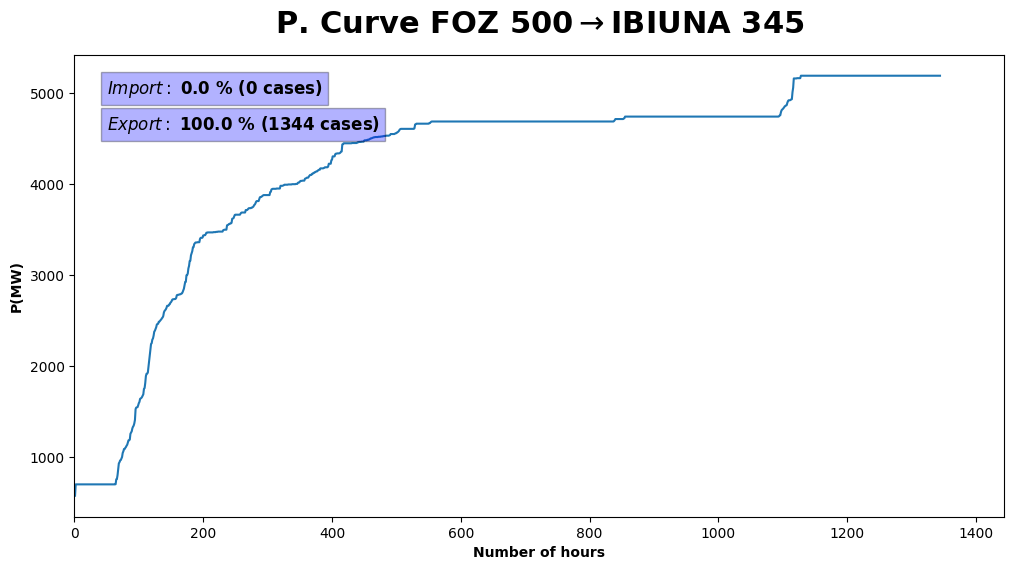

In [ ]:
persistency_curve(L1_FOZ500_PR500_Rect, 'P(MW)', 'FOZ 500', 'IBIUNA 345', 50, 5000, 400)

<b><h2 style="color:#FF851B;">MVAr</h2></b>

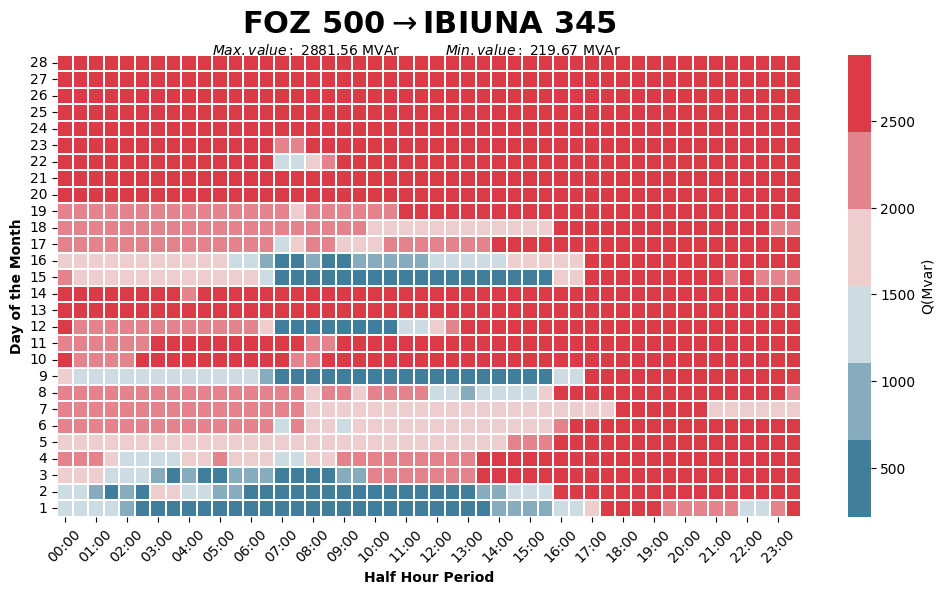

In [ ]:
flow_heatmap(L1_FOZ500_PR500_Rect, 'Q(Mvar)', 'FOZ 500', 'IBIUNA 345')

<b><h2 style="color:#FF851B;">C.PVEL-RO500 (R) - ARARQ2-SP500 (I)</h2></b>

In [7]:
L2_C_PVEL_RO500_Rect = PWF25_links[PWF25_links['Bus Name'] == 'C.PVEL-RO500']
L2_C_PVEL_RO500_Rect = L2_C_PVEL_RO500_Rect.groupby(by = ['Dia','Hora']).agg({'P(MW)':'sum', 'Q(Mvar)':'sum'})
L2_C_PVEL_RO500_Rect = L2_C_PVEL_RO500_Rect.reset_index()
L2_C_PVEL_RO500_Rect['Hora'] = pd.to_datetime(L2_C_PVEL_RO500_Rect['Hora'], format='%H-%M').dt.strftime('%H:%M')
L2_C_PVEL_RO500_Rect

,Dia,Hora,P(MW),Q(Mvar)
0,2,00:00,665.0,266.04
1,2,00:30,579.0,223.28
2,2,01:00,575.0,221.35
3,2,01:30,1050.0,482.35
4,2,02:00,896.0,391.16
...,...,...,...,...
1339,29,21:30,2038.0,927.04
1340,29,22:00,2002.0,905.38
1341,29,22:30,1974.0,888.64
1342,29,23:00,1982.0,893.42


<b><h2 style="color:#FF851B;">MW</h2></b>

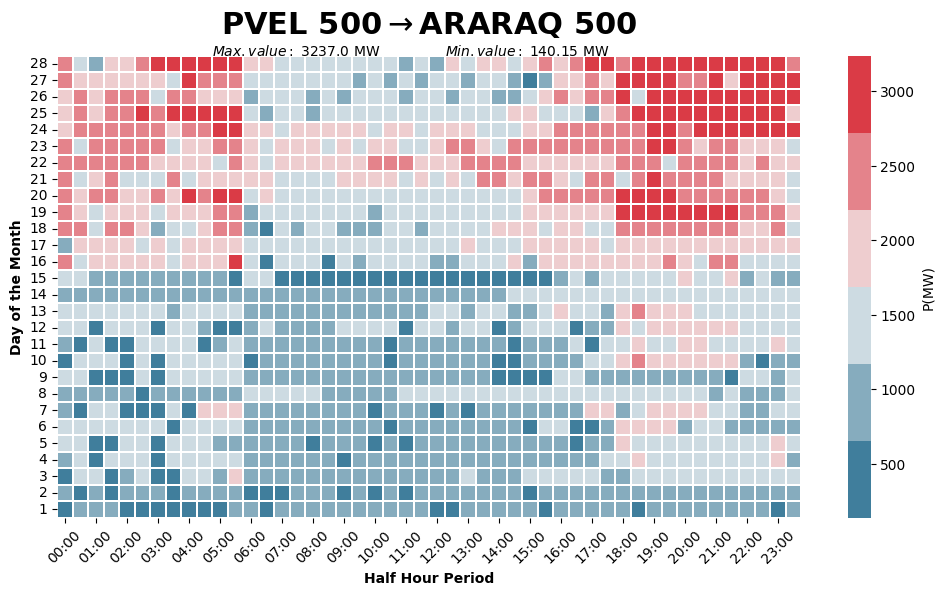

In [ ]:
flow_heatmap(L2_C_PVEL_RO500_Rect, 'P(MW)', 'PVEL 500', 'ARARAQ 500')

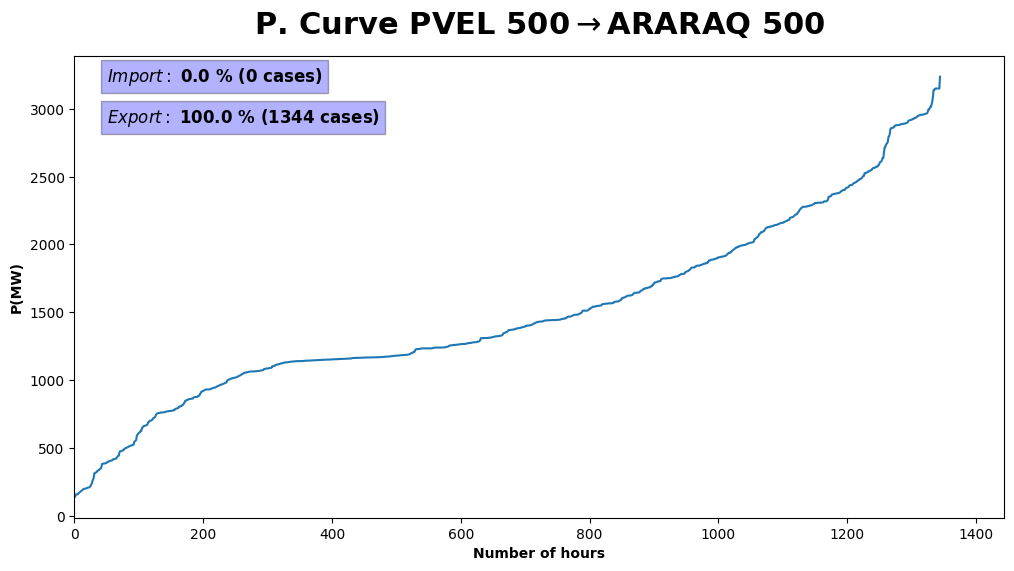

In [ ]:
persistency_curve(L2_C_PVEL_RO500_Rect, 'P(MW)', 'PVEL 500', 'ARARAQ 500', 50, 3200, 300)

<b><h2 style="color:#FF851B;">MVAr</h2></b>

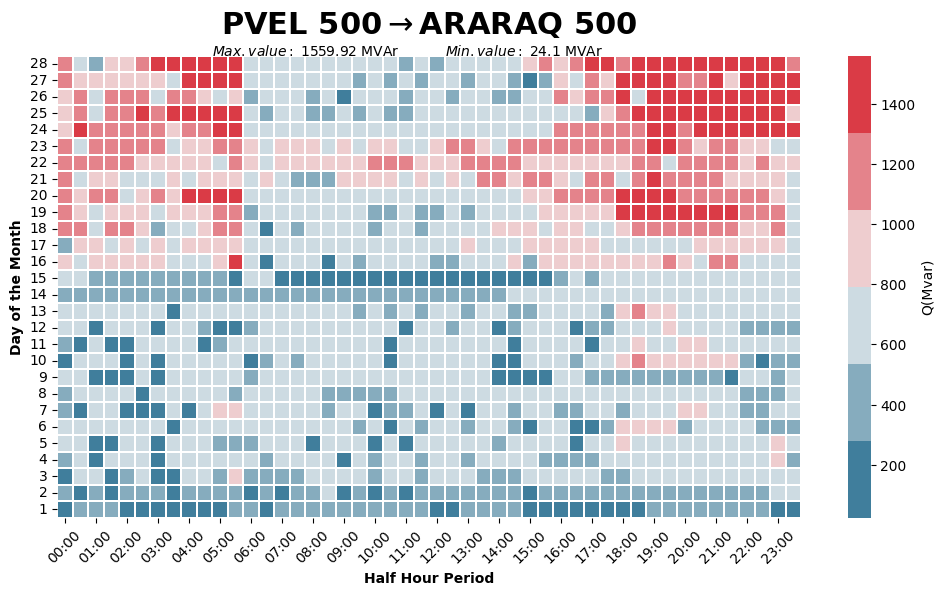

In [ ]:
flow_heatmap(L2_C_PVEL_RO500_Rect, 'Q(Mvar)', 'PVEL 500', 'ARARAQ 500')

<b><h2 style="color:#FF851B;">CPVBTB-RO500 (R) - C.PVEL-RO230 (I)</h2></b>

In [8]:
L3_CPVBTB_RO500_Rect = PWF25_links[PWF25_links['Bus Name'] == 'CPVBTB-RO500']
L3_CPVBTB_RO500_Rect = L3_CPVBTB_RO500_Rect.groupby(by = ['Dia','Hora']).agg({'P(MW)':'sum', 'Q(Mvar)':'sum'})
L3_CPVBTB_RO500_Rect = L3_CPVBTB_RO500_Rect.reset_index()
L3_CPVBTB_RO500_Rect['Hora'] = pd.to_datetime(L3_CPVBTB_RO500_Rect['Hora'], format='%H-%M').dt.strftime('%H:%M')
L3_CPVBTB_RO500_Rect

,Dia,Hora,P(MW),Q(Mvar)
0,2,00:00,448.0,182.26
1,2,00:30,444.0,180.42
2,2,01:00,442.0,179.50
3,2,01:30,40.0,13.85
4,2,02:00,40.0,13.85
...,...,...,...,...
1339,29,21:30,40.0,13.85
1340,29,22:00,40.0,13.85
1341,29,22:30,40.0,13.85
1342,29,23:00,40.0,13.85


<b><h2 style="color:#FF851B;">MW</h2></b>

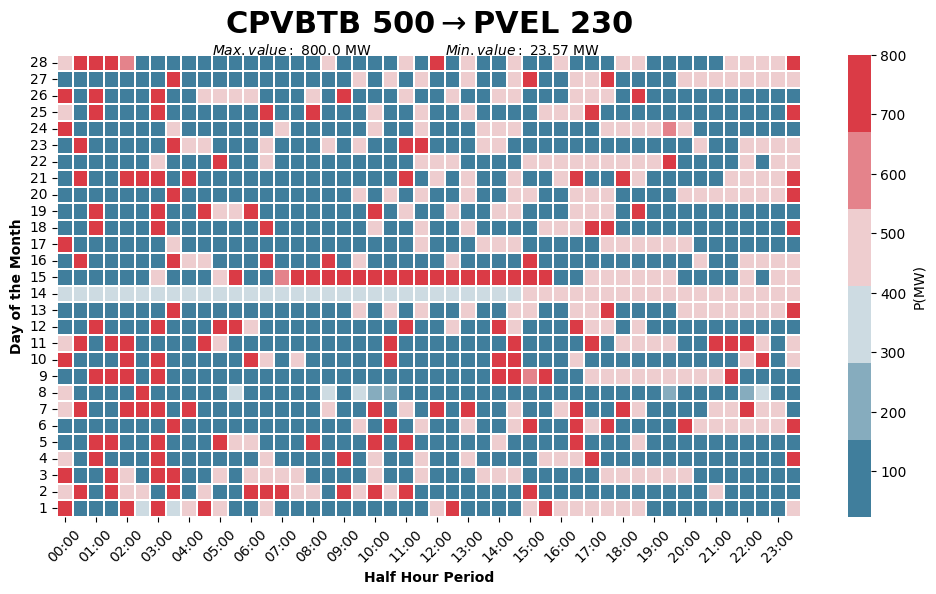

In [ ]:
flow_heatmap(L3_CPVBTB_RO500_Rect, 'P(MW)', 'CPVBTB 500', 'PVEL 230')

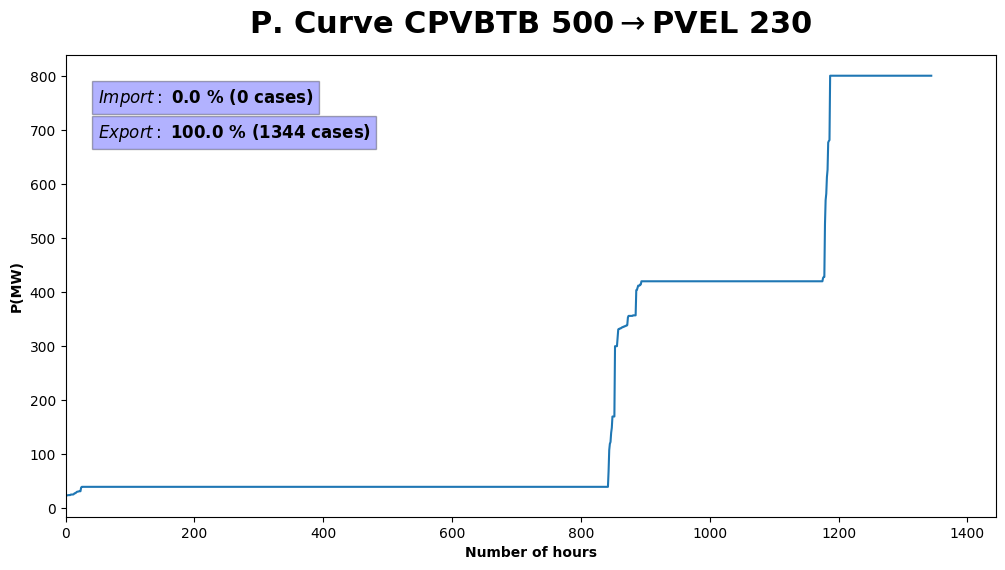

In [ ]:
persistency_curve(L3_CPVBTB_RO500_Rect, 'P(MW)', 'CPVBTB 500', 'PVEL 230', 50, 750, 65)

<b><h2 style="color:#FF851B;">MVAr</h2></b>

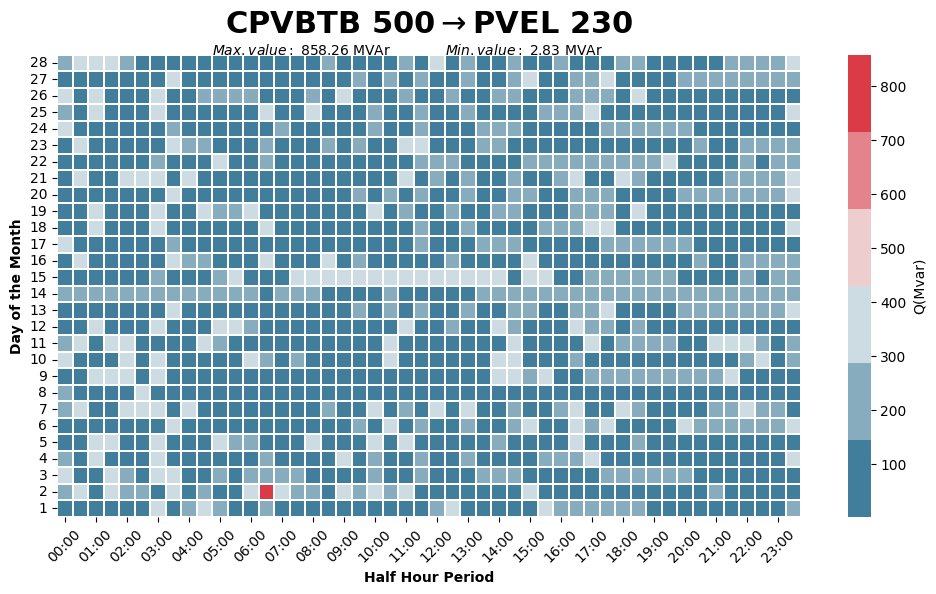

In [ ]:
flow_heatmap(L3_CPVBTB_RO500_Rect, 'Q(Mvar)', 'CPVBTB 500', 'PVEL 230')

<b><h2 style="color:#FF851B;">XINGU-PA500 (R) - ESTREI-MG500 (I) - T.RIO-RJ500 (I)</h2></b>

In [9]:
L4_XINGU_PA500_Rect = PWF25_links[PWF25_links['Bus Name'] == 'XINGU--PA500']
L4_XINGU_PA500_Rect = L4_XINGU_PA500_Rect.groupby(by = ['Dia','Hora']).agg({'P(MW)':'sum', 'Q(Mvar)':'sum'})
L4_XINGU_PA500_Rect = L4_XINGU_PA500_Rect.reset_index()
L4_XINGU_PA500_Rect['Hora'] = pd.to_datetime(L4_XINGU_PA500_Rect['Hora'], format='%H-%M').dt.strftime('%H:%M')
L4_XINGU_PA500_Rect

,Dia,Hora,P(MW),Q(Mvar)
0,2,00:00,492.0,150.22
1,2,00:30,400.0,118.32
2,2,01:00,400.0,118.32
3,2,01:30,400.0,118.32
4,2,02:00,400.0,118.32
...,...,...,...,...
1339,29,21:30,4549.0,2233.80
1340,29,22:00,4491.0,2210.07
1341,29,22:30,4054.0,2002.99
1342,29,23:00,3702.0,1765.79


<b><h2 style="color:#FF851B;">MW</h2></b>

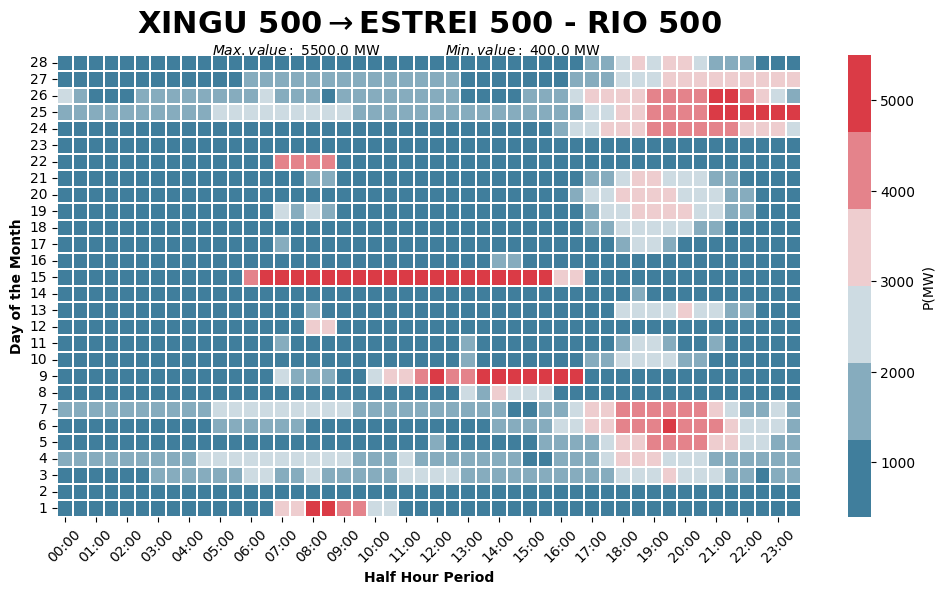

In [ ]:
flow_heatmap(L4_XINGU_PA500_Rect, 'P(MW)', 'XINGU 500', 'ESTREI 500 - RIO 500')

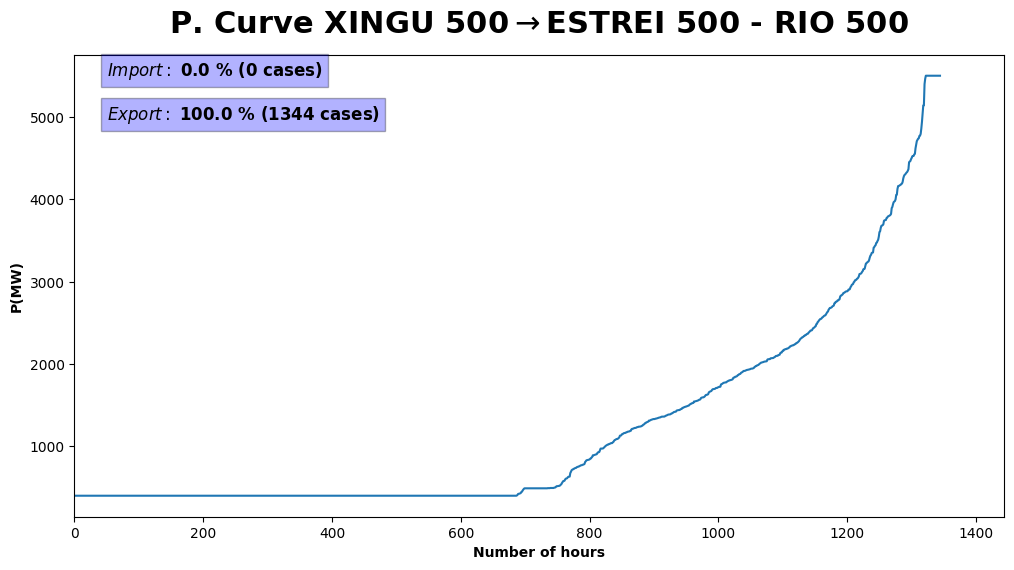

In [ ]:
persistency_curve(L4_XINGU_PA500_Rect, 'P(MW)', 'XINGU 500', 'ESTREI 500 - RIO 500',  50, 5500, 530)

<b><h2 style="color:#FF851B;">MVAr</h2></b>

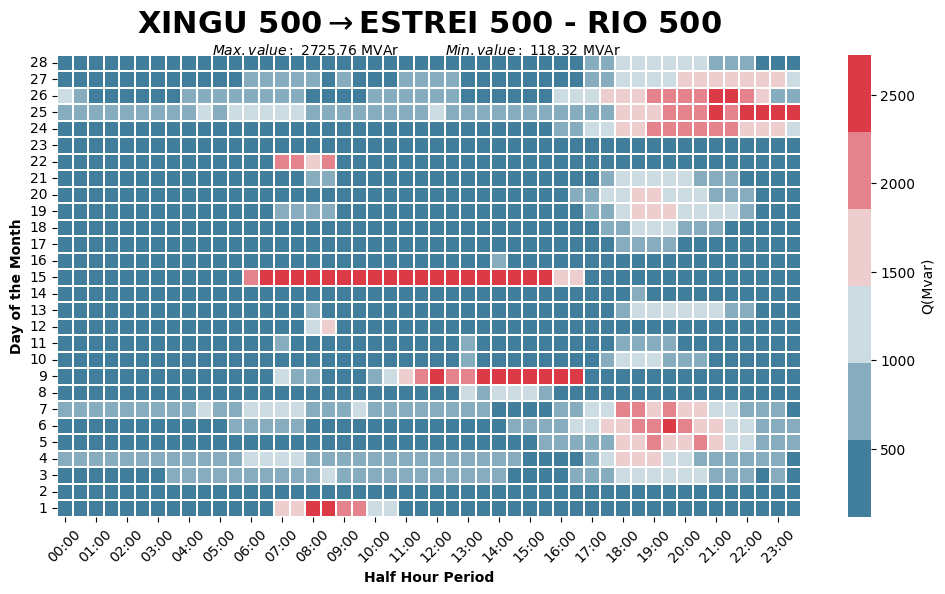

In [ ]:
flow_heatmap(L4_XINGU_PA500_Rect, 'Q(Mvar)', 'XINGU 500', 'ESTREI 500 - RIO 500')

<b><h1 style="color:#FFDC00;">Box Plot & Violin Plot</h1></b>

In [20]:
def create_boxplots(col=None, title=None):

    FOZ_IBIUNA    = np.array(L1_FOZ500_PR500_Rect[col])
    PVELHO_ARARQ  = np.array(L2_C_PVEL_RO500_Rect[col])
    CPVBTB_PVELHO = np.array(L3_CPVBTB_RO500_Rect[col])
    XINGU_EST_RIO = np.array(L4_XINGU_PA500_Rect[col])
    XINGU_EST     = np.array(dfelo4[col])
    XINGU_RIO     = np.array(dfelo5[col])

    all_data = [FOZ_IBIUNA, PVELHO_ARARQ, CPVBTB_PVELHO, XINGU_EST_RIO, XINGU_EST, XINGU_RIO]
    df_dict = {'FOZ_IBIUNA': FOZ_IBIUNA, 'PVELHO_ARARQ': PVELHO_ARARQ, 
            'CPVBTB_PVELHO': CPVBTB_PVELHO, 'XINGU_TOTAL': XINGU_EST_RIO, 
            'XINGU_EST': XINGU_EST, 'XINGU_RIO': XINGU_RIO}
    df_hvdc = pd.DataFrame(df_dict)

    #path = 'E:/FERV/marck/202210_Melhor Previsao FNS/Plots/'

    sns.set_theme(style="ticks")

    if col == 'P(MW)':
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

        sns.boxplot(all_data, palette='Set2')

        ax.yaxis.grid(True)
        ax.set_xticks([y for y in range(len(all_data))],
                        labels=['FOZ_IBIUNA', 'PVELHO_ARARQ', 'CPVBTB_PVELHO', 'XINGU_TOTAL', 'XINGU_EST', 'XINGU_RIO'])
        ax.set_ylabel('P [MW]', weight='bold', fontdict={'fontsize': 15})
        ax.set_xlabel('Fluxos', weight='bold', fontdict={'fontsize': 15})
        ax.set_title('PWF25' + ' ' + title, weight='bold', fontdict={'fontsize': 25})
        ax.set_yticks(np.arange(0, 8500, 1000))
        ax.set_ylim(0-500, 8500)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=13)
        plt.tight_layout()
        
        #plt.savefig(path + f'MW/08 HVDC BoxVio Plots/MW_BoxPlot_V1.png')
        plt.show()

        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()

        smooth_palette = sns.color_palette('viridis', n_colors=len(df_hvdc.columns))
        for i, (col, ax, color) in enumerate(zip(df_hvdc.columns, axes, smooth_palette)):
            sns.boxplot(y=col, data=df_hvdc, ax=ax, color=color)
            ax.set_xlabel(col, weight='bold')
            ax.set_ylabel('P (MW)', weight='bold')

        plt.suptitle('PWF25' + ' ' + title, weight='bold', fontsize=25)

        plt.tight_layout()
        
        #plt.savefig(path + f'MW/08 HVDC BoxVio Plots/MW_BoxPlot_V2.png')
        plt.show()
    else:

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

        sns.boxplot(all_data, palette='Set2')
        #sns.stripplot(all_data, size=2.5, palette='dark:0.3')

        ax.yaxis.grid(True)
        ax.set_xticks([y for y in range(len(all_data))],
                        labels=['FOZ_IBIUNA', 'PVELHO_ARARQ', 'CPVBTB_PVELHO', 'XINGU_TOTAL', 'XINGU_EST', 'XINGU_RIO'])
        ax.set_ylabel('Q [MVAr]', weight='bold', fontdict={'fontsize': 15})
        ax.set_xlabel('Fluxos', weight='bold', fontdict={'fontsize': 15})
        ax.set_title('PWF25' + ' ' + title, weight='bold', fontdict={'fontsize': 25})
        ax.set_yticks(np.arange(0, 4500, 1000))
        ax.set_ylim(0-500, 4000)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=13)
        plt.tight_layout()

        #plt.savefig(path + f'MVAr/08 HVDC BoxVio Plots/MVAr_BoxPlot_V1.png')
        plt.show()

        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()

        smooth_palette = sns.color_palette('viridis', n_colors=len(df_hvdc.columns))
        for i, (col, ax, color) in enumerate(zip(df_hvdc.columns, axes, smooth_palette)):
            sns.boxplot(y=col, data=df_hvdc, ax=ax, color=color)
            ax.set_xlabel(col, weight='bold')
            ax.set_ylabel('Q (MVAr)', weight='bold')

        plt.suptitle('PWF25' + ' ' + title, weight='bold', fontsize=25)
        plt.tight_layout()

        #plt.savefig(path + f'MVAr/08 HVDC BoxVio Plots/MVAr_BoxPlot_V2.png')
        plt.show()
        

def create_violinplots(col=None, title=None):

    FOZ_IBIUNA    = np.array(L1_FOZ500_PR500_Rect[col])
    PVELHO_ARARQ  = np.array(L2_C_PVEL_RO500_Rect[col])
    CPVBTB_PVELHO = np.array(L3_CPVBTB_RO500_Rect[col])
    XINGU_EST_RIO = np.array(L4_XINGU_PA500_Rect[col])
    XINGU_EST     = np.array(dfelo4[col])
    XINGU_RIO     = np.array(dfelo5[col])

    all_data = [FOZ_IBIUNA, PVELHO_ARARQ, CPVBTB_PVELHO, XINGU_EST_RIO, XINGU_EST, XINGU_RIO]
    df_dict = {'FOZ_IBIUNA': FOZ_IBIUNA, 'PVELHO_ARARQ': PVELHO_ARARQ, 
            'CPVBTB_PVELHO': CPVBTB_PVELHO, 'XINGU_TOTAL': XINGU_EST_RIO, 
            'XINGU_EST': XINGU_EST, 'XINGU_RIO': XINGU_RIO}
    df_hvdc = pd.DataFrame(df_dict)

    #path = 'E:/FERV/marck/202210_Melhor Previsao FNS/Plots/'

    if col == 'P(MW)':
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

        sns.violinplot(all_data,
                        showmeans=False,
                        showmedians=True, orient='h', inner="quart", width=1, cut=0)

        # adding horizontal grid lines
        ax.xaxis.grid(True)
        ax.set_yticks([y for y in range(len(all_data))],
                        labels=['FOZ_IBIUNA', 'PVELHO_ARARQ', 'CPVBTB_PVELHO', 'XINGU_TOTAL', 'XINGU_EST', 'XINGU_RIO'], weight='bold')
        ax.set_xlabel('P [MW]', weight='bold', fontdict={'fontsize': 25})
        ax.set_title('PWF25' + ' ' + title, weight='bold', fontdict={'fontsize': 25})
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=20)
        plt.tight_layout()
        #plt.savefig(path + f'MW/08 HVDC BoxVio Plots/MW_VioPlot_V1.png')
        plt.show()
        

        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()

        smooth_palette = sns.color_palette('viridis', n_colors=len(df_hvdc.columns))
        for i, (col, ax, color) in enumerate(zip(df_hvdc.columns, axes, smooth_palette)):
            sns.violinplot(y=col, data=df_hvdc, ax=ax, color=color, cut=0)
            ax.set_xlabel(col, weight='bold')
            ax.set_ylabel('P (MW)', weight='bold')

        plt.suptitle('PWF25' + ' ' + title, weight='bold', fontsize=25)

        plt.tight_layout()
        #plt.savefig(path + f'MW/08 HVDC BoxVio Plots/MW_VioPlot_V2.png')
        plt.show()
    else:
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

        sns.violinplot(all_data,
                        showmeans=False,
                        showmedians=True, orient='h', inner="quart", width=1)

        # adding horizontal grid lines
        ax.xaxis.grid(True)
        ax.set_yticks([y for y in range(len(all_data))],
                        labels=['FOZ_IBIUNA', 'PVELHO_ARARQ', 'CPVBTB_PVELHO', 'XINGU_TOTAL', 'XINGU_EST', 'XINGU_RIO'], weight='bold')
        ax.set_xlabel('Q [MVAr]', weight='bold', fontdict={'fontsize': 25})
        ax.set_title('PWF25' + ' ' + title, weight='bold', fontdict={'fontsize': 25})
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=20)
        plt.tight_layout()

        #plt.savefig(path + f'MVAr/08 HVDC BoxVio Plots/MVAr_VioPlot_V1.png')
        plt.show()

        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()

        smooth_palette = sns.color_palette('viridis', n_colors=len(df_hvdc.columns))
        for i, (col, ax, color) in enumerate(zip(df_hvdc.columns, axes, smooth_palette)):
            sns.violinplot(y=col, data=df_hvdc, ax=ax, color=color)
            ax.set_xlabel(col, weight='bold')
            ax.set_ylabel('Q (MVAr)', weight='bold')

        plt.suptitle('PWF25' + ' ' + title, weight='bold', fontsize=25)
        plt.tight_layout()

        #plt.savefig(path + f'MVAr/08 HVDC BoxVio Plots/MVAr_VioPlot_V2.png')
        plt.show()

<b><h2 style="color:#FF851B;">MW</h2></b>

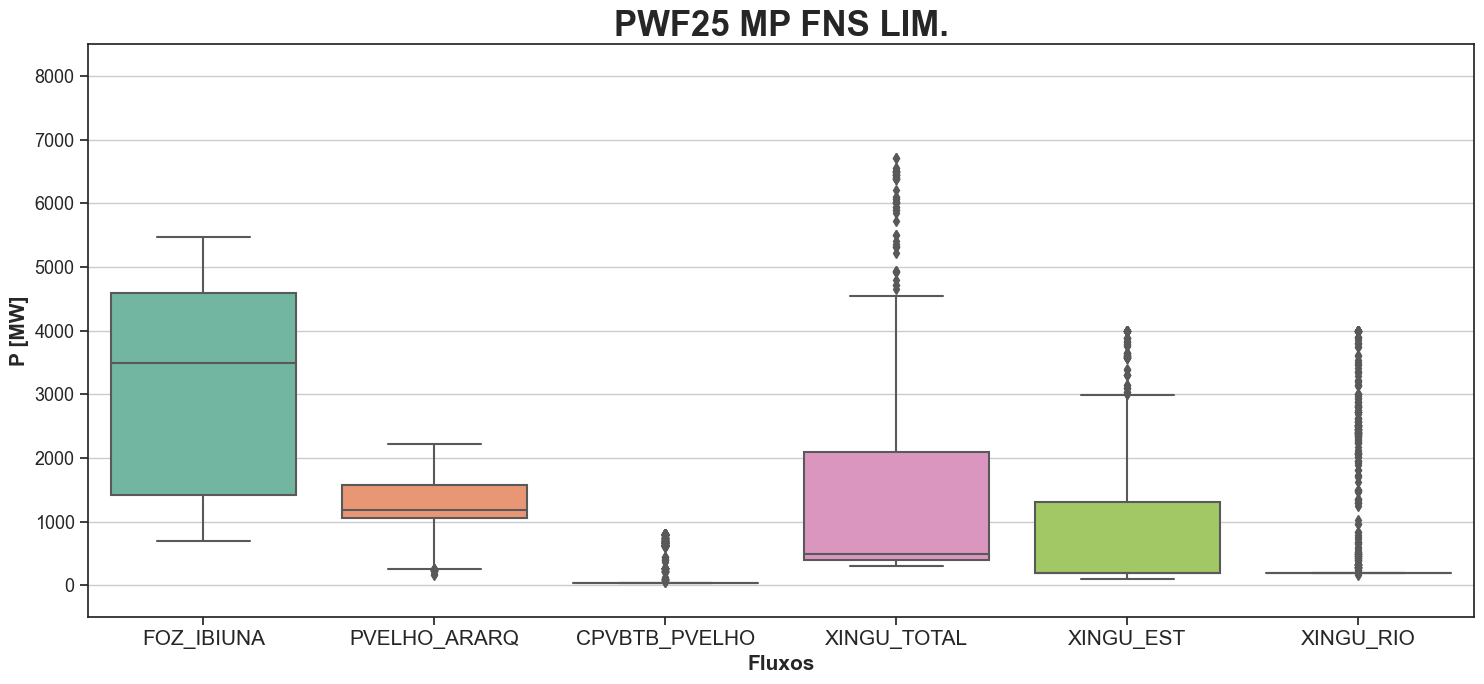

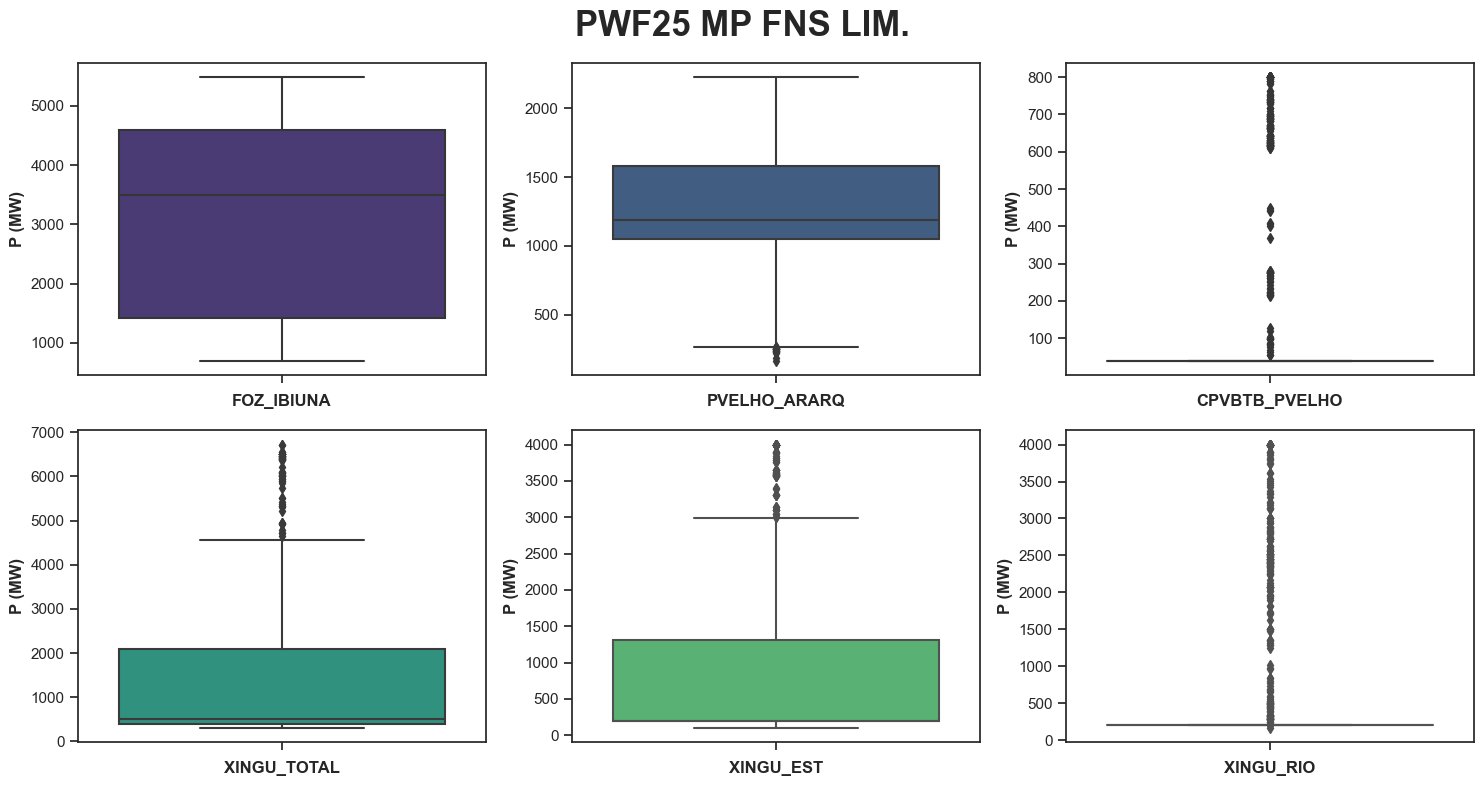

In [18]:
create_boxplots(col='P(MW)', title='MP FNS LIM.')

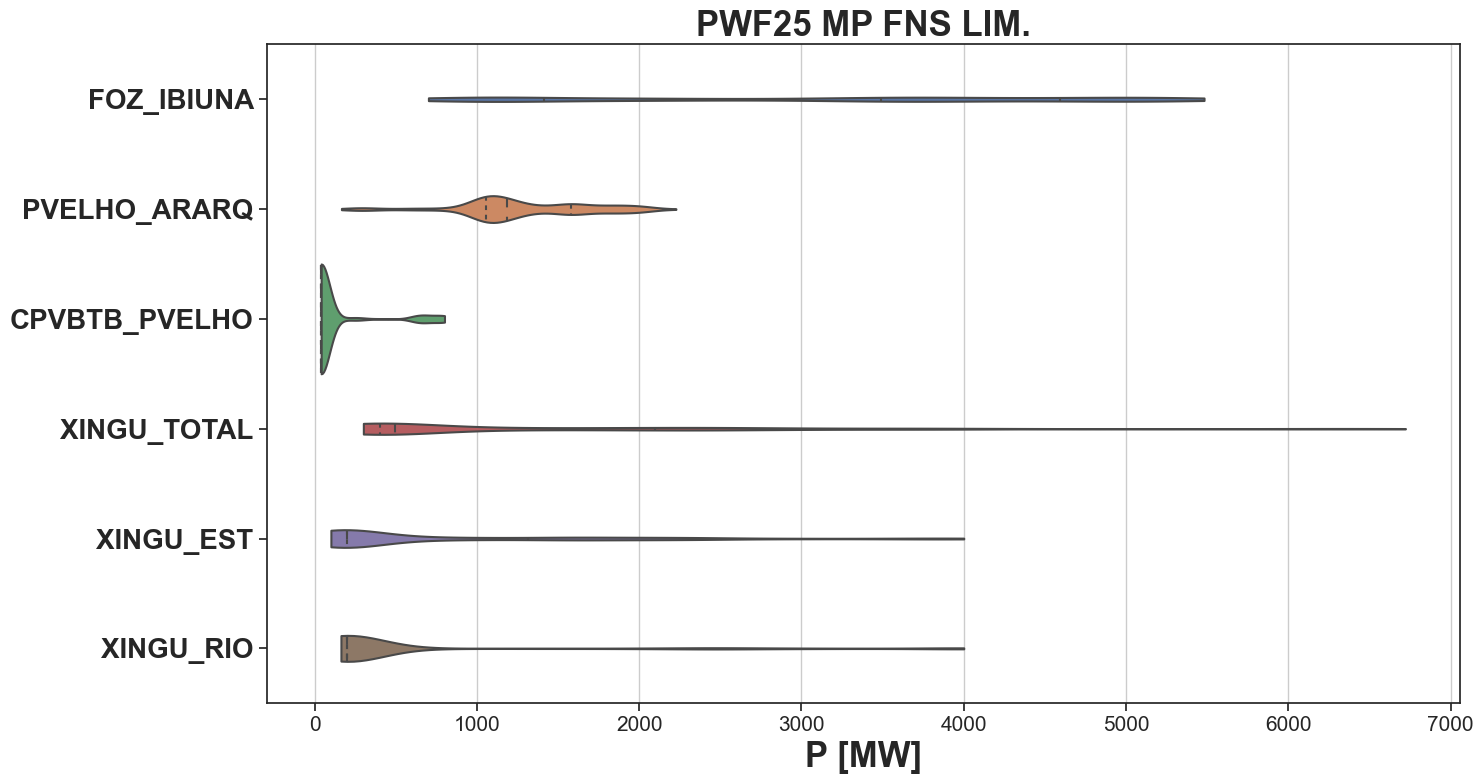

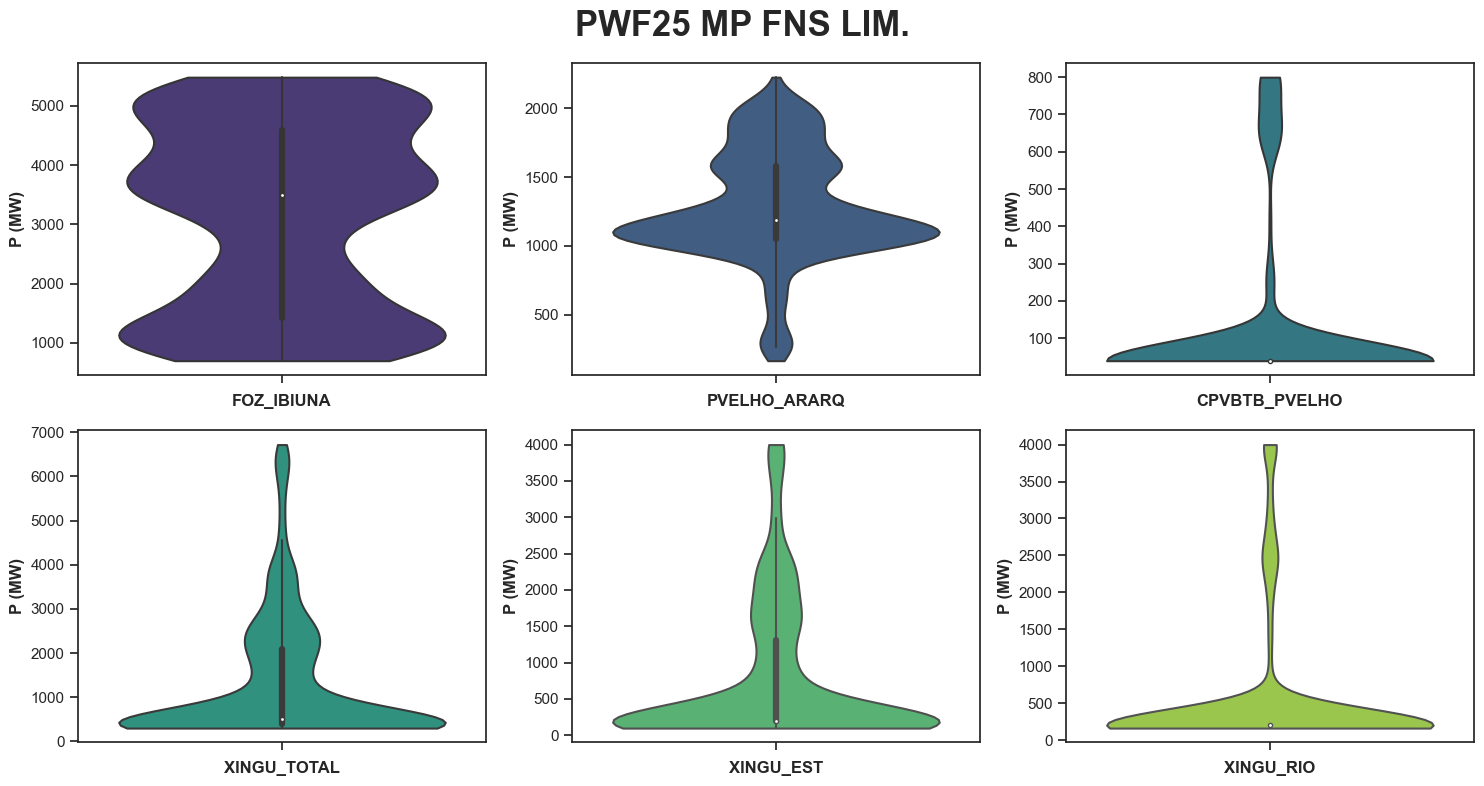

In [21]:
create_violinplots(col='P(MW)', title='MP FNS LIM.')

<b><h2 style="color:#FF851B;">MVAr</h2></b>

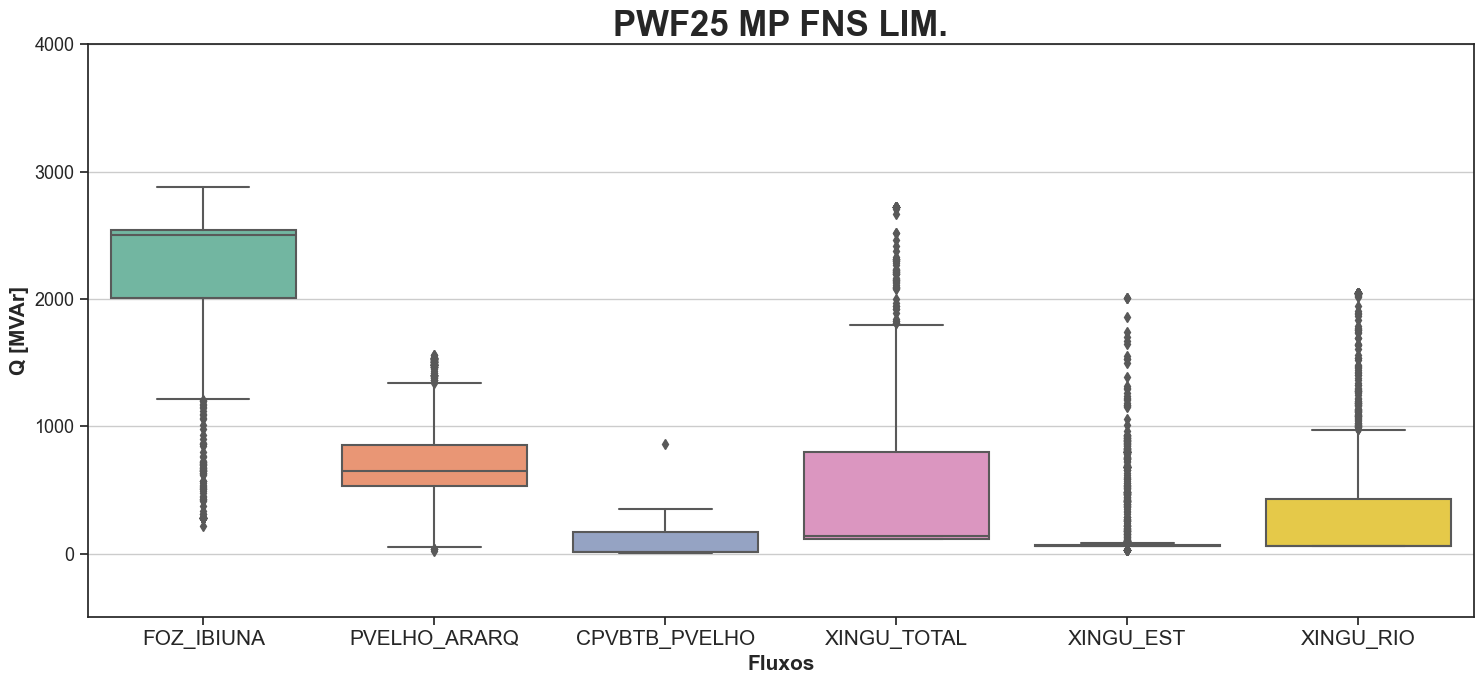

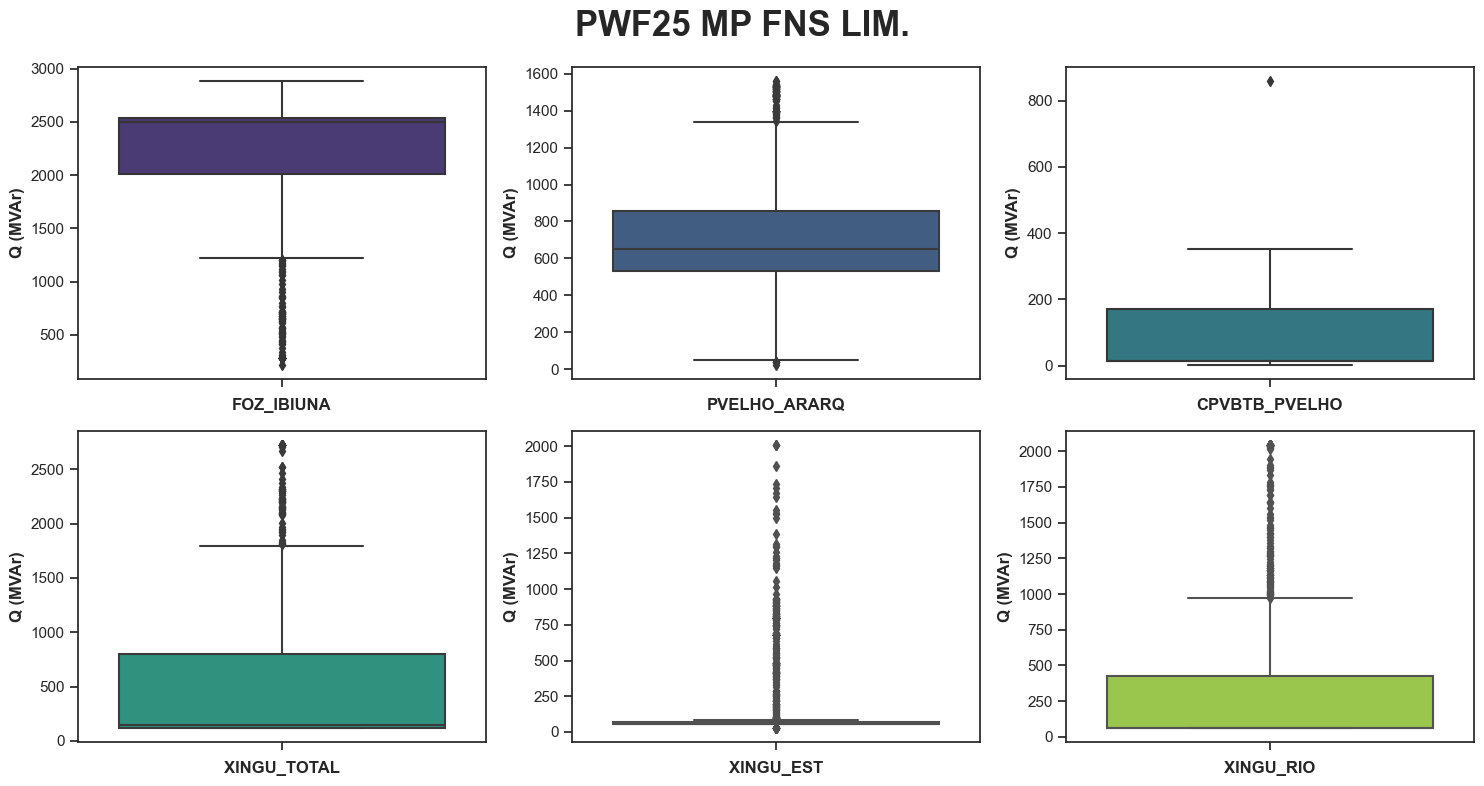

In [ ]:
create_boxplots(col='Q(Mvar)', title='MP FNS LIM.')

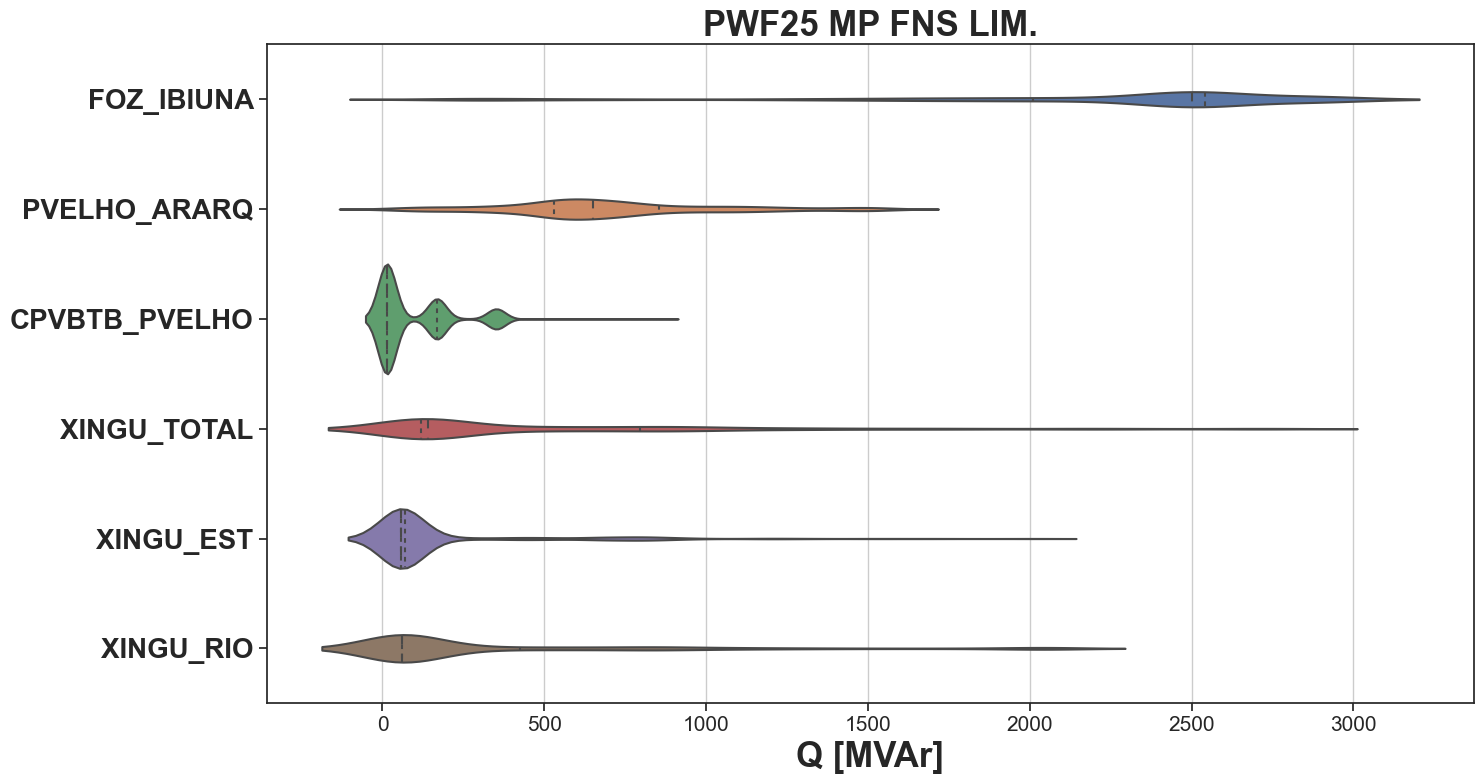

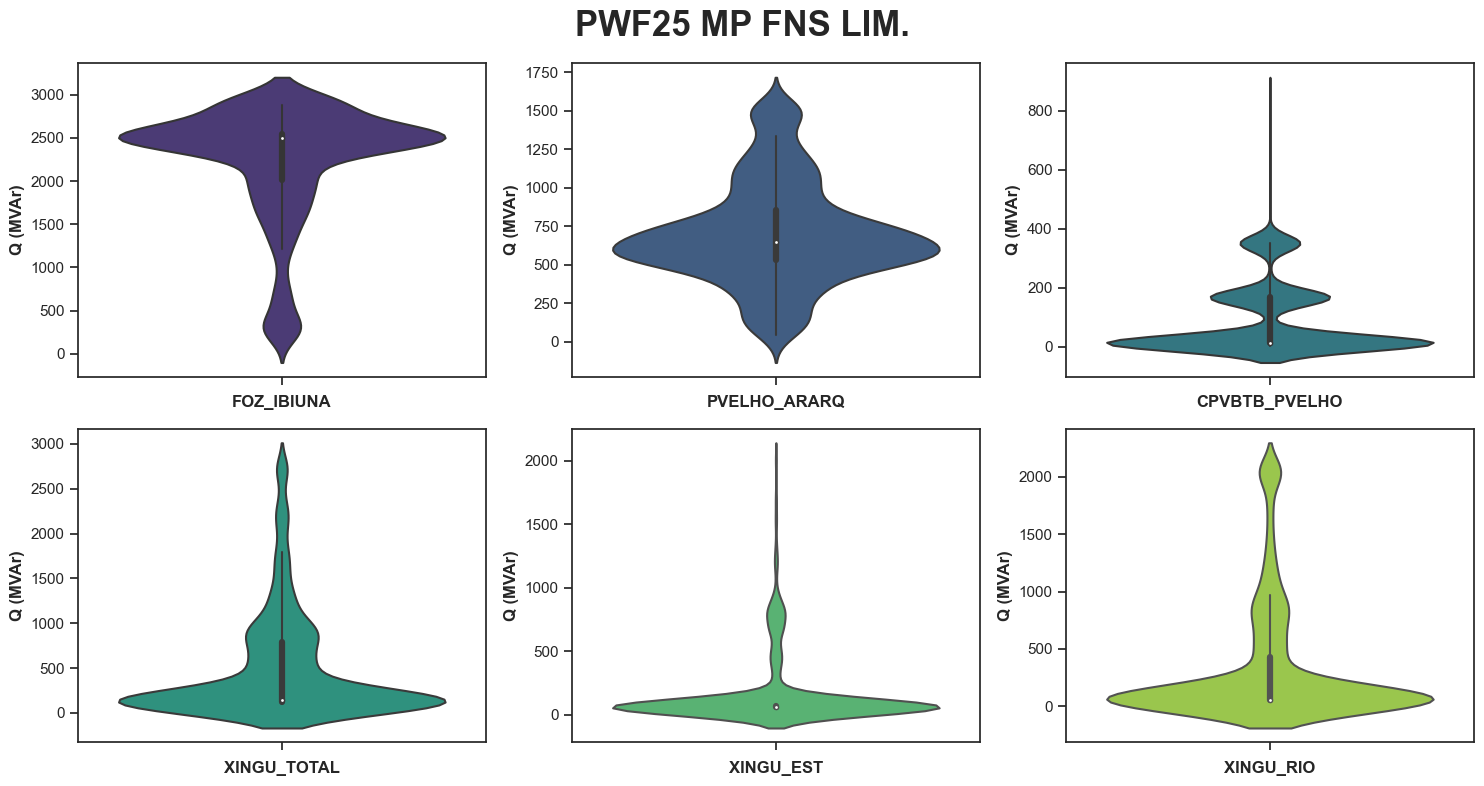

In [ ]:
create_violinplots(col='Q(Mvar)', title='MP FNS LIM.')

In [ ]:
L5_XING_ESTREI_Inv = PWF25_links[PWF25_links['Bus Name'] == 'ESTREI-MG500']
L5_XING_ESTREI_Inv = L5_XING_ESTREI_Inv.groupby(by = ['Dia','Hora']).agg({'P(MW)':'sum', 'Q(Mvar)':'sum'})
L5_XING_ESTREI_Inv = L5_XING_ESTREI_Inv.reset_index()
L5_XING_ESTREI_Inv['Hora'] = pd.to_datetime(L5_XING_ESTREI_Inv['Hora'], format='%H-%M').dt.strftime('%H:%M')
L5_XING_ESTREI_Inv

,Dia,Hora,P(MW),Q(Mvar)
0,1,00:00,-199.13,70.46
1,1,00:30,-199.13,70.46
2,1,01:00,-199.13,70.46
3,1,01:30,-199.13,70.46
4,1,02:00,-199.13,70.46
...,...,...,...,...
1339,28,21:30,-199.13,70.46
1340,28,22:00,-199.13,70.46
1341,28,22:30,-693.24,289.87
1342,28,23:00,-1002.18,455.92


In [ ]:
L6_XING_TRIO_Inv = PWF25_links[PWF25_links['Bus Name'] == 'T.RIO--RJ500']
L6_XING_TRIO_Inv = L6_XING_TRIO_Inv.groupby(by = ['Dia','Hora']).agg({'P(MW)':'sum', 'Q(Mvar)':'sum'})
L6_XING_TRIO_Inv = L6_XING_TRIO_Inv.reset_index()
L6_XING_TRIO_Inv['Hora'] = pd.to_datetime(L6_XING_TRIO_Inv['Hora'], format='%H-%M').dt.strftime('%H:%M')
L6_XING_TRIO_Inv

,Dia,Hora,P(MW),Q(Mvar)
0,1,00:00,-198.95,66.86
1,1,00:30,-198.95,66.86
2,1,01:00,-198.95,66.86
3,1,01:30,-198.95,66.86
4,1,02:00,-198.95,66.86
...,...,...,...,...
1339,28,21:30,-1575.75,800.67
1340,28,22:00,-1250.95,588.87
1341,28,22:30,-198.95,66.86
1342,28,23:00,-198.95,66.86


# Export Data

In [10]:
# dfelo11 = PWF25_links[(PWF25_links['Bus #'] == 85) & (PWF25_links[' Pole #'].isin([1,2]))].groupby(by=['Dia', 'Hora']).agg({' P(MW)': sum, ' Q(Mvar)': sum})
# dfelo11['Nome Elo'] = 'Elo_FOZ-IBIUNA_Pole12'
# dfelo12 = PWF25_links[(PWF25_links['Bus #'] == 85) & (PWF25_links[' Pole #'].isin([3,4]))].groupby(by=['Dia', 'Hora']).agg({' P(MW)': sum, ' Q(Mvar)': sum})
# dfelo12['Nome Elo'] = 'Elo_FOZ-IBIUNA_Pole34'

# dfelo21 = PWF25_links[(PWF25_links['Bus #'] == 7055) & (PWF25_links[' Pole #'].isin([1,2]))].groupby(by=['Dia', 'Hora']).agg({' P(MW)': sum, ' Q(Mvar)': sum})
# dfelo21['Nome Elo'] = 'Elo_PVEL-ARARQ_Pole12'
# dfelo22 = PWF25_links[(PWF25_links['Bus #'] == 7055) & (PWF25_links[' Pole #'].isin([3,4]))].groupby(by=['Dia', 'Hora']).agg({' P(MW)': sum, ' Q(Mvar)': sum})
# dfelo22['Nome Elo'] = 'Elo_PVEL-ARARQ_Pole34'

dfelo1 = PWF25_links[PWF25_links['Bus #'] == 85].groupby(by=['Dia', 'Hora']).agg({'P(MW)': sum, 'Q(Mvar)': sum})
dfelo1['Nome Elo'] = 'Elo_FOZ-IBIUNA'
dfelo2 = PWF25_links[PWF25_links['Bus #'] == 7055].groupby(by=['Dia', 'Hora']).agg({'P(MW)': sum, 'Q(Mvar)': sum})
dfelo2['Nome Elo'] = 'Elo_PVEL-ARARQ'
dfelo3 = PWF25_links[PWF25_links['Bus #'] == 7059].groupby(by=['Dia', 'Hora']).agg({'P(MW)': sum, 'Q(Mvar)': sum})
dfelo3['Nome Elo'] = 'Elo_CPVBTB-PVEL'
# dfelo4 = DCLinks_concatenados[(DCLinks_concatenados['Bus #'] == 8100)].groupby(by=['Dia', 'Hora']).agg({' P(MW)': sum, ' Q(Mvar)': sum})
# dfelo4['Nome Elo'] = 'Elo_XINGU-SE'
dfelo4 = PWF25_links[(PWF25_links['Bus #'] == 8100) & (PWF25_links['Pole #'].isin([1,2]))].groupby(by=['Dia', 'Hora']).agg({'P(MW)': sum, 'Q(Mvar)': sum})
dfelo4['Nome Elo'] = 'Elo_XINGU-ESTREI'
dfelo5 = PWF25_links[(PWF25_links['Bus #'] == 8100) & (PWF25_links['Pole #'].isin([3,4]))].groupby(by=['Dia', 'Hora']).agg({'P(MW)': sum, 'Q(Mvar)': sum})
dfelo5['Nome Elo'] = 'Elo_XINGU-T.RIO'
# Merge all dataframes
#df_HVDC = pd.concat([dfelo1, dfelo2, dfelo3, dfelo4, dfelo5], axis=0, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_CPVBTB-PVEL' ,'Elo_XINGU-ESTREI', 'Elo_XINGU-T.RIO'])
df_HVDC = pd.concat([dfelo1, dfelo2, dfelo3, dfelo4, dfelo5], axis=0, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_CPVBTB-PVEL' ,'Elo_XINGU-EST', 'Elo_XINGU_TRIO'])
# df_HVDC = pd.concat([dfelo11, dfelo12, dfelo21, dfelo22, dfelo3, dfelo4, dfelo5], axis=0)

df_HVDC

P(MW)  Q(Mvar)         Nome Elo
               Dia Hora                                   
Elo_FOZ-IBIUNA 2   00-00  3708.0  1814.64   Elo_FOZ-IBIUNA
                   00-30  3708.0  1814.64   Elo_FOZ-IBIUNA
                   01-00  3708.0  1814.64   Elo_FOZ-IBIUNA
                   01-30  3708.0  1814.64   Elo_FOZ-IBIUNA
                   02-00  3708.0  1814.64   Elo_FOZ-IBIUNA
...                          ...      ...              ...
Elo_XINGU_TRIO 29  21-30  4000.0  2046.34  Elo_XINGU-T.RIO
                   22-00  4000.0  2046.34  Elo_XINGU-T.RIO
                   22-30  3854.0  1945.02  Elo_XINGU-T.RIO
                   23-00  3502.0  1707.82  Elo_XINGU-T.RIO
                   23-30  3130.0  1468.34  Elo_XINGU-T.RIO

[6720 rows x 3 columns]

In [11]:
df_HVDC_exp = df_HVDC.reset_index().drop('level_0', axis=1)
df_HVDC_exp['Hora'] = pd.to_datetime(df_HVDC_exp['Hora'], format='%H-%M').dt.strftime('%H:%M')
df_HVDC_exp

,Dia,Hora,P(MW),Q(Mvar),Nome Elo
0,2,00:00,3708.0,1814.64,Elo_FOZ-IBIUNA
1,2,00:30,3708.0,1814.64,Elo_FOZ-IBIUNA
2,2,01:00,3708.0,1814.64,Elo_FOZ-IBIUNA
3,2,01:30,3708.0,1814.64,Elo_FOZ-IBIUNA
4,2,02:00,3708.0,1814.64,Elo_FOZ-IBIUNA
...,...,...,...,...,...
6715,29,21:30,4000.0,2046.34,Elo_XINGU-T.RIO
6716,29,22:00,4000.0,2046.34,Elo_XINGU-T.RIO
6717,29,22:30,3854.0,1945.02,Elo_XINGU-T.RIO
6718,29,23:00,3502.0,1707.82,Elo_XINGU-T.RIO


In [12]:
df_HVDC_exp.to_csv('data/PTOPER_202210_PWF25_AllDecomp.csv', index=False)

In [13]:
dfelo1 = dfelo1.reset_index()
dfelo1['Hora'] = pd.to_datetime(dfelo1['Hora'], format='%H-%M').dt.strftime('%H:%M')
dfelo2 = dfelo2.reset_index()
dfelo2['Hora'] = pd.to_datetime(dfelo2['Hora'], format='%H-%M').dt.strftime('%H:%M')
dfelo3 = dfelo3.reset_index()
dfelo3['Hora'] = pd.to_datetime(dfelo3['Hora'], format='%H-%M').dt.strftime('%H:%M')
dfelo4 = dfelo4.reset_index()
dfelo4['Hora'] = pd.to_datetime(dfelo4['Hora'], format='%H-%M').dt.strftime('%H:%M')
dfelo5 = dfelo5.reset_index()
dfelo5['Hora'] = pd.to_datetime(dfelo5['Hora'], format='%H-%M').dt.strftime('%H:%M')

In [14]:
col  = 'P(MW)'
Dia  = np.array(dfelo1['Dia'])
Hora = np.array(dfelo1['Hora'])
FOZ_IBIUNA    = np.array(dfelo1[col])
PVELHO_ARARQ  = np.array(dfelo2[col])
CPVBTB_PVELHO = np.array(dfelo3[col])
XINGU_ESTREI  = np.array(dfelo4[col])
XINGU_TRIO    = np.array(dfelo5[col])

all_data = [FOZ_IBIUNA, PVELHO_ARARQ, CPVBTB_PVELHO, XINGU_ESTREI, XINGU_TRIO]

df_dict = {'Dia': Dia, 'Hora': Hora, 'FOZIB_MW': FOZ_IBIUNA, 'PVLARRQ_MW': PVELHO_ARARQ, 
           'CPVPVL_MW': CPVBTB_PVELHO, 'XESTR_MW': XINGU_ESTREI, 'XTRIO_MW': XINGU_TRIO}
df_pwf25 = pd.DataFrame(df_dict)
df_pwf25

,Dia,Hora,FOZIB_MW,PVLARRQ_MW,CPVPVL_MW,XESTR_MW,XTRIO_MW
0,2,00:00,3708.0,665.0,448.0,200.0,292.0
1,2,00:30,3708.0,579.0,444.0,200.0,200.0
2,2,01:00,3708.0,575.0,442.0,200.0,200.0
3,2,01:30,3708.0,1050.0,40.0,200.0,200.0
4,2,02:00,3708.0,896.0,40.0,200.0,200.0
...,...,...,...,...,...,...,...
1339,29,21:30,3177.0,2038.0,40.0,549.0,4000.0
1340,29,22:00,3303.0,2002.0,40.0,491.0,4000.0
1341,29,22:30,3027.0,1974.0,40.0,200.0,3854.0
1342,29,23:00,2638.0,1982.0,40.0,200.0,3502.0


In [15]:
df_pwf25.to_csv('data/PTOPER_202210_PWF25_OPF.csv', index=False)